##### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
import os
sys.path.insert(0, os.getcwd())

In [5]:
import torch 
import pickle
import nibabel

from jrieke.utils import load_nifti, save_nifti
from innvestigator import InnvestigateModel
from settings import settings
from utils import load_data, scale_mask
from jrieke import interpretation
from nmm_mask_areas import all_areas

import numpy as np
import pickle
import jrieke.models as models


for k in settings.keys():
    print("Adding " + k + " to namespace")
    globals()[k] = settings[k]

Adding model_path to namespace
Adding data_path to namespace
Adding ADNI_DIR to namespace
Adding train_h5 to namespace
Adding val_h5 to namespace
Adding holdout_h5 to namespace
Adding binary_brain_mask to namespace
Adding nmm_mask_path to namespace
Adding nmm_mask_path_scaled to namespace


In [12]:
# where to store the individual maps
output_dir = "/ritter/share/projects/Methods/LRP/data/forDi/"

## Load model

In [6]:
device = 6
net = models.ClassificationModel3D_2Node()
net.cuda(device)
net.load_state_dict(torch.load(model_path,
                              map_location='cpu'))
net.eval()
net = torch.nn.Sequential(net, torch.nn.Softmax(dim=1))
inn_model = InnvestigateModel(net, lrp_exponent=1,
                                  method="b-rule",
                                  beta=0, epsilon=1e-6).cuda(device)
inn_model.eval();


Hence, if in any layer only positive contributions exist, the overall relevance will not be conserved.



## Load ADNI Data

In [7]:
import h5py

In [8]:
def min_max_normalization(subset):
    for i in range(len(subset)):
        subset[i] -= np.min(subset[i])
        subset[i] /= np.max(subset[i])
    return subset
    
def load_data(skip_train=True, skip_val=True, skip_test=False, dtype=np.float32):
    """ Load hdf5 files and extract columns. """
    X_train, y_train, X_val, y_val, X_holdout, y_holdout = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    # train
    if not skip_train:
        train_h5_ = h5py.File(train_h5, 'r')
        X_train, y_train = train_h5_['X'], train_h5_['y']
        X_train = np.expand_dims(np.array(X_train, dtype=dtype), 1)
        X_train = min_max_normalization(X_train)
        y_train = np.array(y_train)
        print("Total training set length: {}".format(len(y_train)))
        print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
        print("Number of AD patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))
    if not skip_val:
        # val
        val_h5_ = h5py.File(val_h5, 'r')
        X_val, y_val = val_h5_['X'], val_h5_['y']
        X_val = np.expand_dims(np.array(X_val, dtype=dtype), 1)
        X_val = min_max_normalization(X_val)
        y_val = np.array(y_val)
        print("Total validation set length: {}".format(len(y_val)))
    if not skip_test:
        # test
        holdout_h5_ = h5py.File(holdout_h5, 'r')
        X_holdout, y_holdout = holdout_h5_['X'], holdout_h5_['y']
        X_holdout = np.expand_dims(np.array(X_holdout, dtype=dtype), 1)
        X_holdout = min_max_normalization(X_holdout)
        y_holdout = np.array(y_holdout)
        print("Total test set length: {}".format(len(y_holdout)))
   
    return X_train, y_train, X_val, y_val, X_holdout, y_holdout


In [9]:
X_train, y_train, X_val, y_val, X_holdout, y_holdout = load_data()

image_shape = X_holdout.shape[1:-1]

Total test set length: 172


## Load mask

In [10]:
mri_shape = X_holdout.shape[2:]

if False:
    neuromorph_map = nibabel.load(nmm_mask_path).get_data()
    nmm_mask = scale_mask(neuromorph_map, mri_shape)
    save_nifti(nmm_mask_path_scaled, nmm_mask)
else:
    nmm_mask = load_nifti(nmm_mask_path_scaled)

# all_areas holds the area name and a tuple with the minimum 
# idx in the NMM mask and the maximum idx in the NMM mask belonging to that area
area_masks = {k: None for k in all_areas.keys()}
for name, (min_idx, max_idx) in all_areas.items():
    area_mask = np.zeros(mri_shape)
    area_mask[np.logical_and(nmm_mask>=min_idx, nmm_mask<=max_idx)] = 1
    area_masks[name] = area_mask

## Evaluate Guided Backprop and LRP on dataset

In [11]:
def run_guided_backprop(net, image_tensor):
    return interpretation.guided_backprop(net, image_tensor, cuda=True, verbose=False, apply_softmax=False)

def run_LRP(net, image_tensor):
    return inn_model.innvestigate(in_tensor=image_tensor, rel_for_class=1)

In [12]:
cases = ["AD", "HC", "TP", "TN", "FP", "FN"]
mean_maps_GB = {case: np.zeros(mri_shape) for case in cases}
mean_maps_LRP = {case: np.zeros(mri_shape) for case in cases}
rs_per_area_LRP = {case: {k: [] for k in all_areas.keys()} for case in cases}
rs_per_area_GB = {case: {k: [] for k in all_areas.keys()} for case in cases}
counts = {case: 0 for case in cases}
area_sizes = {k: 0 for k in all_areas.keys()}

#####  Run evaluation

In [17]:
num_samples = len(X_holdout)

ad_score_list = []

for i, (image, label) in enumerate(zip(X_holdout, y_holdout)):
    image_tensor = torch.Tensor(image[None]).cuda(device)   
    #GB_map = run_guided_backprop(inn_model, image_tensor).squeeze()
    AD_score, LRP_map = run_LRP(inn_model, image_tensor)
    AD_score = AD_score[0][1].detach().cpu().numpy()
    LRP_map = LRP_map.detach().numpy().squeeze()
    
    
    true_case = "AD" if label else "HC"
    if AD_score.round() and label:
        case = "TP"
    elif AD_score.round() and not label:
        case = "FP"
    elif not AD_score.round() and label:
        case = "FN"
    elif not AD_score.round() and not label:
        case = "TN"
    
    save_nifti(os.path.join(output_dir, "LRP_{:03d}_pred_{}.nii".format(i, case)),
           LRP_map)
    
    print("Completed {0:3.2f}%  \r".format(100*(i+1)/num_samples), end="")
        

In [18]:
nifti = load_nifti(os.path.join(output_dir, "LRP_035_pred_TN.nii"))

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

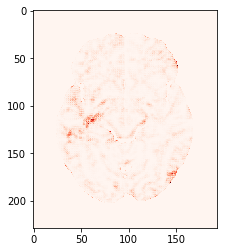

In [23]:
plt.imshow(np.rot90(nifti[:,:,68]), cmap='Reds')